In [1]:
import yfinance as yf
import pandas as pd
import quandl
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
key='3NXCnuBDyDnnhec-yWs8' #nasdaq auth
from sqlalchemy import create_engine

D:\Python\Python311\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
#Databases
engine = create_engine('sqlite:///Database.db')

In [3]:
sp_df = yf.download('^GSPC')

[*********************100%***********************]  1 of 1 completed


In [4]:
#symbols = ('^VIX9D', '^VIX', '^VIX3M', '^VIX6M') #VIX, VIX9D, VIX3M, VIX6M, VXO (sp100), VXN (nasdaq), RVX (russel), TYVIX (10y note)
symbols = ('^VIX', '^VIX3M','^GSPC')

In [5]:
prices = []
for symbol in symbols:
    prices.append(yf.download(symbol, start='1990-01-01')['Adj Close'])
    prices = [price.replace('Adj Close', symbol) for price in prices]
    print(symbol)

[*********************100%***********************]  1 of 1 completed
^VIX
[*********************100%***********************]  1 of 1 completed
^VIX3M
[*********************100%***********************]  1 of 1 completed
^GSPC


In [6]:
sig_df = pd.concat(prices, axis=1)
sig_df = sig_df.set_axis(symbols, axis=1, inplace=False).dropna()

C:\Users\mydea\AppData\Local\Temp\ipykernel_2908\2745441948.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  sig_df = sig_df.set_axis(symbols, axis=1, inplace=False).dropna()


In [8]:
#indicators
sig_df['VRATIO'] = sig_df['^VIX3M']/sig_df['^VIX'] #contango/bwd in cash contracts
sig_df['CTNGO'] = (quandl.get("CHRIS/CBOE_VX1", authtoken=key)['Close'])/(quandl.get("CHRIS/CBOE_VX2", authtoken=key)['Close'])
sig_df['RVOLA'] = sig_df['^GSPC'].pct_change().rolling(30).std()*(252**0.5)*100 #realized volatility
sig_df['RVOLA5'] = sig_df['^GSPC'].pct_change().rolling(5).std()*(252**0.5)*100 #realized volatility
sig_df['RVOLA10'] = sig_df['^GSPC'].pct_change().rolling(10).std()*(252**0.5)*100 #realized volatility
sig_df['VRP'] = sig_df['^VIX'] - sig_df['RVOLA10'] #vola risk premium
sig_df['VRP5'] = sig_df['VRP'].rolling(10).mean() #vrp 5 day ma
sig_df['FVRP'] = (sig_df['^VIX'].ewm(span=7, adjust=False).mean()) - sig_df['RVOLA5'] #fast vola risk premium
sig_df['VIXEMA'] = sig_df['^VIX'].ewm(span=7, adjust=False).mean()

In [9]:
sig_df

,^VIX,^VIX3M,^GSPC,VRATIO,CTNGO,RVOLA,RVOLA5,RVOLA10,VRP,VRP5,FVRP,VIXEMA
Date,,,,,,,,,,,,
2006-07-17,18.639999,18.049999,1234.489990,0.968348,1.020588,NaN,NaN,NaN,NaN,NaN,NaN,18.639999
2006-07-18,17.740000,17.219999,1236.859985,0.970688,1.058368,NaN,NaN,NaN,NaN,NaN,NaN,18.414999
2006-07-19,15.550000,15.600000,1259.810059,1.003215,1.076266,NaN,NaN,NaN,NaN,NaN,NaN,17.698750
2006-07-20,16.209999,16.309999,1249.130005,1.006169,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,17.326562
2006-07-21,17.400000,17.040001,1240.290039,0.979310,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,17.344921
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,20.870001,24.129999,3844.820068,1.156205,NaN,18.597923,18.546469,20.738063,0.131937,2.321259,2.984783,21.531252
2022-12-27,21.650000,24.430000,3829.250000,1.128407,NaN,18.366491,17.383812,18.583454,3.066546,2.374295,4.177127,21.560939
2022-12-28,22.139999,24.580000,3783.219971,1.110208,NaN,18.498789,19.540579,17.793970,4.346029,2.818426,2.165125,21.705704


In [4]:
engine.table_names()

C:\Users\mydea\AppData\Local\Temp\ipykernel_5384\4162273999.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['CTNGO',
 'FVRP',
 'RVOLA',
 'RVOLA10',
 'RVOLA5',
 'VIXEMA',
 'VRATIO',
 'VRP',
 'VRP5',
 '^GSPC',
 '^VIX',
 '^VIX3M']

In [13]:
for id in sig_df.columns:
    sig_df.to_sql(id, engine)
    print(id + ' imported')

ValueError: Table '^VIX' already exists.

In [8]:
fred_df = pd.read_sql('WALCL', engine).set_index('index')
#vix_df = pd.read_sql('VRATIO', engine).set_index('Date')

OperationalError: (sqlite3.OperationalError) near "WALCL": syntax error
[SQL: WALCL]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [6]:
vix_df.VRATIO

Date
2006-07-17    0.968348
2006-07-18    0.970688
2006-07-19    1.003215
2006-07-20    1.006169
2006-07-21    0.979310
                ...   
2022-12-23    1.156205
2022-12-27    1.128407
2022-12-28    1.110208
2022-12-29    1.117071
2022-12-30    1.120905
Name: VRATIO, Length: 4145, dtype: float64

<AxesSubplot: xlabel='Date'>

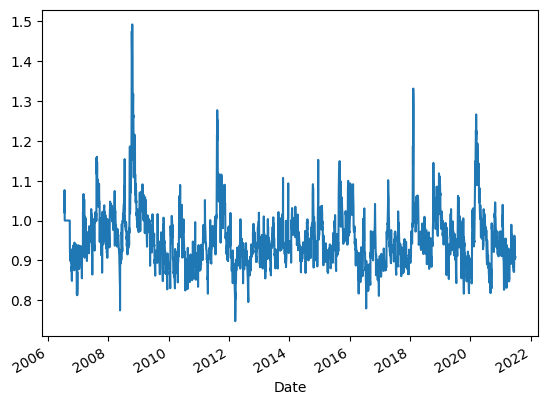

In [11]:
sig_df['CTNGO'].plot()

In [10]:
df = pd.concat([sp_df, sig_df], axis=1)

In [11]:
df = df.dropna()

In [18]:
def indicator(data):
    data = data
    return data

#df = df.dropna()
#df['Volume'].fillna(method='bfill')
#df['Volume'].fillna(method='ffill')
#backtest strategy
class Cross(Strategy):
    #n1 = 50
    #n2 = 100
    sellsig = 0.85
    buysig = 1.0
    
    def init(self):
        pass
        #self.fv = self.I(indicator, self.data.SP_FV, plot=True)
        #self.close = self.data.Close
        #self.fv = self.data.SP_FV
        #self.sma1 = self.I(ta.trend.sma_indicator, pd.Series(close), self.n1)
        #self.p1 = 350
        #self.p2 = -150
        
    def next(self):
        if crossover(self.data.VRATIO, self.buysig):
            self.position.close()
            self.buy()
        elif crossover(self.sellsig, self.data.VRATIO):
            self.position.close()
            self.sell()

In [19]:
bt = Backtest(df, Cross, cash=100000, commission=0.002, exclusive_orders=True)
output = bt.run()
output

Start                     2006-08-28 00:00:00
End                       2022-12-23 00:00:00
Duration                   5961 days 00:00:00
Exposure Time [%]                   96.789102
Equity Final [$]                207752.371339
Equity Peak [$]                 265280.360405
Return [%]                         107.752371
Buy & Hold Return [%]               195.35098
Return (Ann.) [%]                    4.583997
Volatility (Ann.) [%]               20.336758
Sharpe Ratio                         0.225405
Sortino Ratio                        0.332787
Calmar Ratio                         0.129555
Max. Drawdown [%]                  -35.382678
Avg. Drawdown [%]                   -2.226771
Max. Drawdown Duration     1109 days 00:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                  140
Win Rate [%]                             45.0
Best Trade [%]                      33.983976
Worst Trade [%]                    -16.380728
Avg. Trade [%]                    

In [28]:
import backtesting
backtesting.set_bokeh_output(notebook=False)
bt.plot(plot_width=900, reverse_indicators=True)

D:\Python\Python311\Lib\site-packages\bokeh\models\formatters.py:399: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first prodvided: '%d %b' 
  warnings.warn(f"DatetimeFormatter scales now only accept a single format. Using the first prodvided: {fmt[0]!r} ")
D:\Python\Python311\Lib\site-packages\bokeh\models\formatters.py:399: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first prodvided: '%m/%Y' 
  warnings.warn(f"DatetimeFormatter scales now only accept a single format. Using the first prodvided: {fmt[0]!r} ")


GridPlot(id='p3469', ...)

In [29]:
output['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,71,132,139,1404.693795,1402.040039,-188.416649,-0.001889,2007-03-09,2007-03-20,11 days
1,71,139,167,1404.844119,1494.069946,6335.033728,0.063513,2007-03-20,2007-04-30,41 days
2,70,167,170,1497.058086,1495.560059,-104.861931,-0.001001,2007-04-30,2007-05-03,3 days
3,70,170,196,1498.551179,1507.640015,636.218516,0.006065,2007-05-03,2007-06-11,39 days
4,70,196,199,1510.655295,1515.579956,344.726296,0.003260,2007-06-11,2007-06-14,3 days
...,...,...,...,...,...,...,...,...,...,...
135,54,3944,3947,4231.025238,4159.779785,-3847.254469,-0.016839,2022-04-28,2022-05-03,5 days
136,54,3947,4050,4168.099345,3687.010010,-25978.824088,-0.115422,2022-05-03,2022-09-29,149 days
137,54,4050,4052,3694.384030,3609.780029,-4568.616026,-0.022901,2022-09-29,2022-10-03,4 days
138,54,4052,4062,3616.999589,3638.649902,1169.116901,0.005986,2022-10-03,2022-10-17,14 days


In [31]:
optim = bt.optimize(sellsig = [1.0, 0.8, 0.1],
                   buysig = [1.0, 1.2, 0.1],
                   #constraint = lambda x: x.buysig - x.sellsig > 20,
                   maximize='Return [%]')
                #maximize='Sharpe Ratio')
optim

  0%|          | 0/9 [00:00<?, ?it/s]

Start                     2006-08-28 00:00:00
End                       2022-12-22 00:00:00
Duration                   5960 days 00:00:00
Exposure Time [%]                   96.788321
Equity Final [$]                210658.529929
Equity Peak [$]                 266717.233883
Return [%]                          110.65853
Buy & Hold Return [%]              193.627941
Return (Ann.) [%]                    4.674256
Volatility (Ann.) [%]               21.404868
Sharpe Ratio                         0.218374
Sortino Ratio                        0.319785
Calmar Ratio                         0.079166
Max. Drawdown [%]                  -59.043393
Avg. Drawdown [%]                    -2.16657
Max. Drawdown Duration     2211 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                  130
Win Rate [%]                        45.384615
Best Trade [%]                      33.983976
Worst Trade [%]                    -27.052266
Avg. Trade [%]                    

<AxesSubplot: xlabel='Trade Date'>

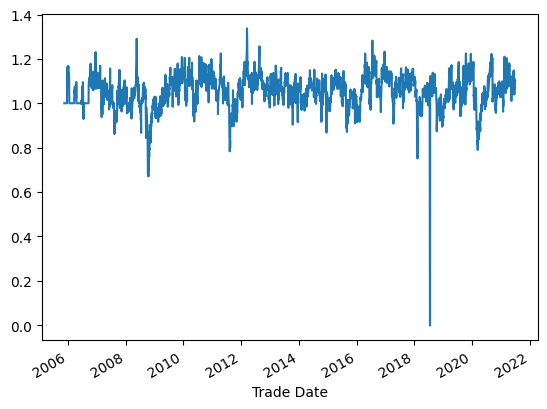

In [12]:
VX1 = quandl.get("CHRIS/CBOE_VX1")['Close']
VX2 = quandl.get("CHRIS/CBOE_VX2")['Close']
(VX2/VX1).plot()

In [ ]:
#https://medium.com/datadriveninvestor/how-to-harness-the-power-of-vix-to-protect-your-portfolio-part-3-bbfa12ba7c38
#https://www.quantconnect.com/tutorials/strategy-library/exploiting-term-structure-of-vix-futures